In [88]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
os.chdir('/Users/jackholder/Documents/Columbia/Big Data & Machine Learning/')
df_train = pd.read_csv('train_labels.csv')
df_train.head()

,breed,id
0,Chihuahua,Trainn02085620_10621.jpg
1,Chihuahua,Trainn02085620_10976.jpg
2,Chihuahua,Trainn02085620_11140.jpg
3,Chihuahua,Trainn02085620_11238.jpg
4,Chihuahua,Trainn02085620_11258.jpg


In [24]:
df_test = pd.read_csv('test_labels.csv')
df_test.head()

,breed,id
0,Chihuahua,Testn02085620_10074.jpg
1,Chihuahua,Testn02085620_10131.jpg
2,Chihuahua,Testn02085620_1073.jpg
3,Chihuahua,Testn02085620_11337.jpg
4,Chihuahua,Testn02085620_11477.jpg


In [25]:
n = len(df_train)
breed = set(df_train['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [26]:
width = 299
X_train = np.zeros((n, width, width, 3), dtype=np.uint8)
y_train = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X_train[i] = cv2.resize(cv2.imread('Train/%s' % df_train['id'][i]), (width, width))
    y_train[i][class_to_num[df_train['breed'][i]]] = 1


 28%|██▊       | 3312/12000 [00:15<00:40, 211.96it/s]


 55%|█████▌    | 6625/12000 [00:31<00:25, 212.47it/s]


 80%|████████  | 9658/12000 [00:47<00:11, 203.31it/s]


100%|██████████| 12000/12000 [00:58<00:00, 203.46it/s]

In [27]:
n = len(df_test)
breed = set(df_test['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [28]:
width = 299
X_test = np.zeros((n, width, width, 3), dtype=np.uint8)
y_test = np.zeros((n, n_class), dtype=np.uint8)
for i in tqdm(range(n)):
    X_test[i] = cv2.resize(cv2.imread('Test/%s' % df_test['id'][i]), (width, width))
    y_test[i][class_to_num[df_test['breed'][i]]] = 1


 38%|███▊      | 3284/8580 [00:16<00:26, 197.34it/s]


 76%|███████▌  | 6501/8580 [00:32<00:10, 197.68it/s]


100%|██████████| 8580/8580 [00:43<00:00, 196.26it/s]

Having a look at the data...

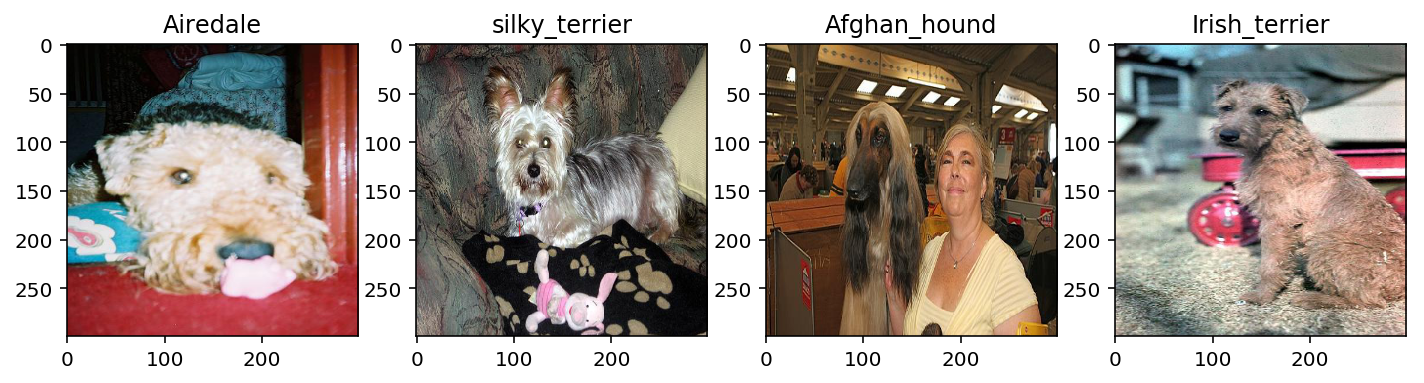

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.figure(figsize=(12, 6))
for i in range(4):
    random_index = random.randint(0, n-1)
    plt.subplot(1, 4, i+1)
    plt.imshow(X_train[random_index][:,:,::-1])
    plt.title(num_to_class[y_train[random_index].argmax()])

In [47]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

Using TensorFlow backend.


Now we fit the pre-trained model (InceptionV3) on our dataset, both the training and testing data, using code from Yang Peiwen (cheers).

In [51]:
def get_features(MODEL, X):
    cnn_model = MODEL(include_top=False, input_shape=(width, width, 3), weights='imagenet')
    
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name='preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)

    features = cnn_model.predict(X, batch_size=64, verbose=1)
    return features

In [52]:
train_features = get_features(InceptionV3, X_train)
train_features = np.concatenate([train_features], axis=-1)

12000/12000 [==============================] - 6462s   


In [53]:
test_features = get_features(InceptionV3, X_test)
test_features = np.concatenate([test_features], axis=-1)

8580/8580 [==============================] - 4538s  


Once we have extracted the features, we use a transfer learning approach with a softmax classifier to optimize the final layer of the net.

In [66]:
inputs = Input(train_features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation='softmax')(x)
model = Model(inputs, x)
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
h = model.fit(train_features, y_train, batch_size=256, epochs=20, 
              validation_data=(test_features, y_test))

Train on 12000 samples, validate on 8580 samples
Epoch 1/20
12000/12000 [==============================] - 2s - loss: 2.5865 - acc: 0.4823 - val_loss: 1.2196 - val_acc: 0.7568
Epoch 2/20
12000/12000 [==============================] - 1s - loss: 1.0366 - acc: 0.7415 - val_loss: 0.7726 - val_acc: 0.7942
Epoch 3/20
12000/12000 [==============================] - 1s - loss: 0.7482 - acc: 0.7874 - val_loss: 0.6588 - val_acc: 0.8106
Epoch 4/20
12000/12000 [==============================] - 1s - loss: 0.6325 - acc: 0.8083 - val_loss: 0.6141 - val_acc: 0.8140
Epoch 5/20
12000/12000 [==============================] - 1s - loss: 0.5705 - acc: 0.8213 - val_loss: 0.5928 - val_acc: 0.8167
Epoch 6/20
12000/12000 [==============================] - 1s - loss: 0.5217 - acc: 0.8341 - val_loss: 0.5868 - val_acc: 0.8154
Epoch 7/20
12000/12000 [==============================] - 1s - loss: 0.4846 - acc: 0.8440 - val_loss: 0.5789 - val_acc: 0.8179
Epoch 8/20
12000/12000 [==============================] - 1s -

Next we plot the results from the optimization... it looks good overall, around 83% accuracy in the testing data.

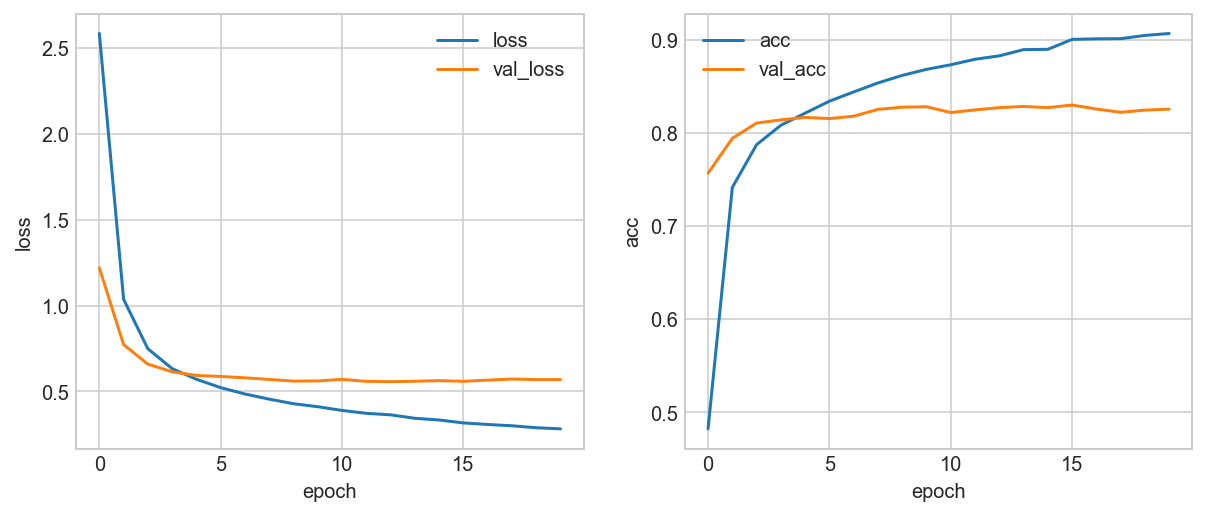

In [94]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_style("whitegrid")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1, 2, 2)
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.ylabel('acc')
plt.xlabel('epoch')

No image classification would be complete without matching up some images with their predictions...

In [69]:
y_pred = model.predict(test_features, batch_size=128)

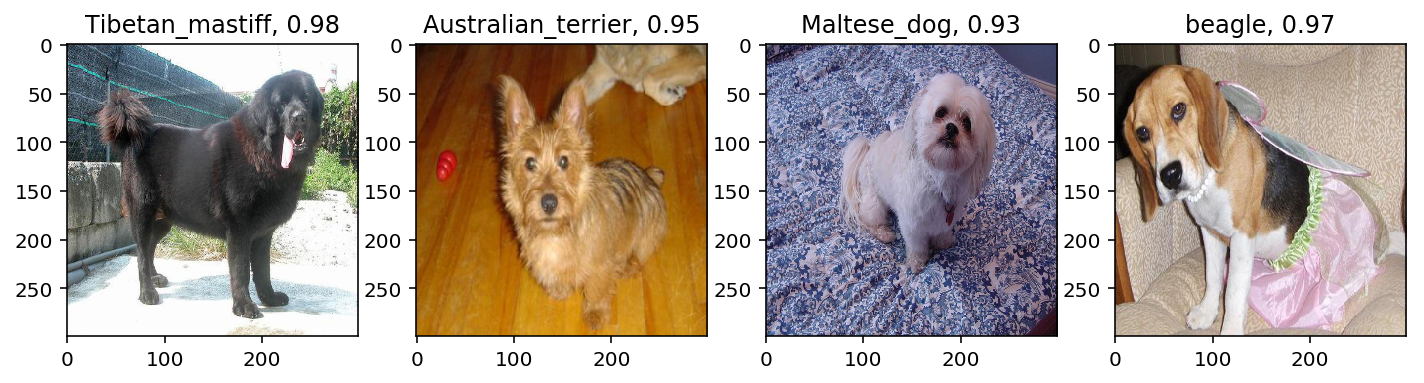

In [86]:
plt.figure(figsize=(12, 6))
for i in range(4):
    random_index = random.randint(0, n-1)
    plt.subplot(1, 4, i+1)
    plt.imshow(X_test[random_index][:,:,::-1])
    plt.title("%s, %0.2f" %(num_to_class[y_pred[random_index].argmax()], max(y_pred[random_index])))